# Charging Infrastructure

This section examines how charging infrastructure shapes the adoption of electric vehicles (EVs) in France. The analysis focuses on:

- **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)
- **User experience and perceived sufficiency**  
  (Personal experience with charging—problems encountered, perceived adequacy of the network)
- **Improvement priorities**  
  (User priorities for future infrastructure: coverage, reliability, speed, information)
- **Influence of user profile**  
  (How geographic area and ownership status affect charging experience and perceptions)
- **Impact on adoption intent**  
  (How these combined factors influence the intention to adopt or repurchase an EV)

Many of these factors are interrelated: for example, perceived sufficiency is shaped by both access and user experience, and user profile influences both awareness and experience.

## Setup

In [80]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display
from scipy.stats import pearsonr
from wordcloud import WordCloud, STOPWORDS

In [81]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [82]:
df = pd.read_csv(r'FinalEvAdoptionInFranceResults.csv')
# for col in df.columns:
#     values = df[col].dropna().astype(str)
#     split_vals = []
#     for val in values:
#         split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
#     unique_vals = pd.unique(split_vals)
#     if len(unique_vals) <= 20:
#         print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
#         if len(unique_vals) > 20:
#             print("... (troncature à 20 valeurs)")
#         print("-" * 60)
# print(list(df.columns))

In [83]:
# Création des colonnes de base pour l'analyse


df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)

# Région (origine géographique)
region_col = [col for col in df.columns if "Habitez-vous dans" in col][0]
df['region'] = df[region_col]

# Tranche d'âge
age_col = [col for col in df.columns if "tranche d’âge" in col][0]
df['age_group'] = df[age_col]

# Nombre de véhicules et de personnes (déjà présents mais on s'assure de leur type)
df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

vehicle_cols = [
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)',
]
driving_exp_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"

# Recodage échelle 4 points
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4,
    "Tout à fait d’accord": 4,  # gestion des accents différents
}
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]


grouped = df.groupby(geo_col)[economic_cols].mean().transpose()
grouped_percent = grouped * 100

df['intention_adopter'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(likert_map)
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"
df[driving_exp_col + "_score"] = df[driving_exp_col].map(likert_map)
df['repurchase_score'] = df[repurchase_col].map(likert_map)


exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
connaissance_col = "À quel point diriez-vous que vous connaissez bien les offres actuelles de véhicules électriques et d'infrastructures associées ?"

# Recodage expérience : 1 = Oui, 0 = Non
df['exp_ev'] = df[exp_col].map({'Oui, j’ai conduit': 3,'Oui, j’étais passager': 2,'Non, jamais': 1})


connaissance_map = {
        "Pas du tout, je ne m’y suis jamais vraiment intéressé": 1,
        "Un peu, je connais quelques modèles et options": 2,
        "Assez bien, je vois passer des informations": 3,
        "Très bien, je suis régulièrement les nouveautés": 4
    }
df['connaissance_score'] = df[connaissance_col].map(connaissance_map)

aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"
def count_aides(cell):
    if pd.isna(cell) or not cell.strip():
        return 0
    return len([aide.strip() for aide in cell.split(',') if aide.strip() and aide.strip().lower() != "aucune"])

df['score_aides_connues'] = df[aides_col].apply(count_aides)
stopwords = set(STOPWORDS)


C:\Users\Mango\AppData\Local\Temp\ipykernel_40596\3799749869.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)


## **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)

In [84]:
from collections import Counter
from IPython.display import display
import seaborn as sns
import pandas as pd

col_acteurs = "Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n"

def count_actors(cell):
    if pd.isna(cell) or cell.strip() == "Non, je ne connais aucun de ces noms":
        return 0
    return len([x for x in cell.split(",") if x.strip()])

df['nb_acteurs_connus'] = df[col_acteurs].apply(count_actors)
import matplotlib.pyplot as plt
# Affichage sous forme de joli tableau
table = df['nb_acteurs_connus'].value_counts().sort_index().reset_index()
table.columns = ["Nombre d'acteurs connus", "Nombre de répondants"]
table["%"] = (table["Nombre de répondants"] / table["Nombre de répondants"].sum() * 100).round(1)
display(table.style.background_gradient(cmap="Blues").format(precision=0))

# Compter la fréquence de chaque acteur (tous séparés par virgule)
all_actors = df[col_acteurs].dropna().loc[lambda x: x != "Non, je ne connais aucun de ces noms"]
actor_list = [actor.strip() for cell in all_actors for actor in cell.split(",") if actor.strip()]
actor_counts = Counter(actor_list)
actor_counts_df = pd.DataFrame(actor_counts.items(), columns=["Acteur", "Nombre de répondants"]).sort_values("Nombre de répondants", ascending=False)
actor_counts_df["%"] = (actor_counts_df["Nombre de répondants"] / len(df) * 100).round(1)
display(actor_counts_df)


,Nombre d'acteurs connus,Nombre de répondants,%
0,0,82,35
1,1,49,21
2,2,30,13
3,3,30,13
4,4,20,9
5,5,9,4
6,6,1,0
7,7,1,0
8,8,8,3
9,9,2,1


,Acteur,Nombre de répondants,%
0,TotalEnergies,120,51.7
1,Tesla Superchargeurs,107,46.1
4,Ionity,46,19.8
3,Zeplug,35,15.1
5,ChargeMap,34,14.7
2,Shell Recharge,27,11.6
6,Electra,27,11.6
8,Freshmile,15,6.5
10,Autre,2,0.9
7,Schneider Electric,1,0.4


 Awareness of Charging Operators

### Table 1. Number of Charging Operators Known

| Number of Operators Known | Number of Respondents | %   |
|--------------------------|----------------------|-----|
| 0                        | 82                   | 35% |
| 1                        | 49                   | 21% |
| 2                        | 30                   | 13% |
| 3                        | 30                   | 13% |
| 4                        | 20                   | 9%  |
| 5                        | 9                    | 4%  |
| 6                        | 1                    | 0%  |
| 7                        | 1                    | 0%  |
| 8                        | 8                    | 3%  |
| 9                        | 2                    | 1%  |

### Table 2. Most Frequently Cited Charging Operators

| Operator              | Number of Respondents | %     |
|-----------------------|----------------------|-------|
| TotalEnergies         | 120                  | 51.7% |
| Tesla Superchargeurs  | 107                  | 46.1% |
| Ionity                | 46                   | 19.8% |
| Zeplug                | 35                   | 15.1% |
| ChargeMap             | 34                   | 14.7% |
| Shell Recharge        | 27                   | 11.6% |
| Electra               | 27                   | 11.6% |
| Freshmile             | 15                   | 6.5%  |
| Others (each <1%)     | 1–2                  | <1%   |


**Main Findings**

- **Limited Awareness:**  
  Over one-third of respondents (35%) do not know any charging operator, and only 21% can name just one. Very few are familiar with more than four operators.
- **Concentration on Major Brands:**  
  Awareness is highly concentrated: TotalEnergies (52%) and Tesla Superchargeurs (46%) are by far the most recognized, followed by Ionity, Zeplug, and ChargeMap. All other operators are cited by less than 12% of respondents.
- **Long Tail of Low Awareness:**  
  Many operators are almost unknown to the public, with several cited by only one or two people.


**Brief Analysis**

These results highlight a significant lack of awareness about the diversity of charging operators among the general public. Most respondents can only name one or two brands, and knowledge is focused on a few major players. This limited awareness could be a barrier to EV adoption, as potential users may feel uncertain about the availability and reliability of charging options. Improving communication and visibility for a wider range of operators could help build confidence in the charging network and support broader adoption of electric vehicles.

In [85]:
# On retire les lignes où il manque une des deux variables
df_reg = df[['connaissance_score', 'intention_adopter']].dropna()

# Recode intention_adopter en binaire : 1 si intention forte (>=3), 0 sinon
y_bin = (df_reg['intention_adopter'] >= 3).astype(int)
X = sm.add_constant(df_reg['connaissance_score'])

# Régression logistique binaire
model = sm.Logit(y_bin, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.687477
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      intention_adopter   No. Observations:                  142
Model:                          Logit   Df Residuals:                      140
Method:                           MLE   Df Model:                            1
Date:                Mon, 26 May 2025   Pseudo R-squ.:                0.004616
Time:                        03:57:09   Log-Likelihood:                -97.622
converged:                       True   LL-Null:                       -98.074
Covariance Type:            nonrobust   LLR p-value:                    0.3413
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5274      0.441      1.195      0.232      -0.338       1.393
conna

**Relationship Between Knowledge Score and Intention to Adopt an EV**

### Logistic Regression Results

| Variable            | Coefficient | Std. Error | z      | P-value | 95% CI (lower) | 95% CI (upper) |
|---------------------|-------------|------------|--------|---------|----------------|----------------|
| Intercept (const)   | 0.527       | 0.441      | 1.20   | 0.232   | -0.338         | 1.393          |
| Knowledge Score     | -0.186      | 0.196      | -0.95  | 0.343   | -0.569         | 0.198          |

- **Number of observations:** 142  
- **Pseudo R²:** 0.0046  
- **Log-Likelihood:** -97.62  
- **Model p-value (LLR):** 0.3413

### Main Findings

- The coefficient for the knowledge score (`connaissance_score`) is negative (-0.186) but **not statistically significant** (p = 0.343).
- The model as a whole does not explain much variance in the intention to adopt an EV (Pseudo R² ≈ 0.005).
- The intercept is also not significant.


### Brief Analysis

These results suggest that, in this sample, the self-reported knowledge of electric vehicle offers and infrastructure is **not a significant predictor** of a strong intention to adopt an EV. In other words, simply knowing more about EVs and charging infrastructure does not appear to increase (or decrease) the likelihood that someone will express a strong intention to adopt. This finding highlights the importance of other factors—such as personal experience, perceived convenience, or attitudes toward technology—in shaping adoption intent. Communication strategies should therefore go beyond just increasing knowledge and also address practical and emotional barriers to adoption.

Moyenne du nombre d'aides connues selon le score subjectif :
connaissance_score
1    1.050000
2    1.723404
3    1.725490
4    1.592593
Name: score_aides_connues, dtype: float64


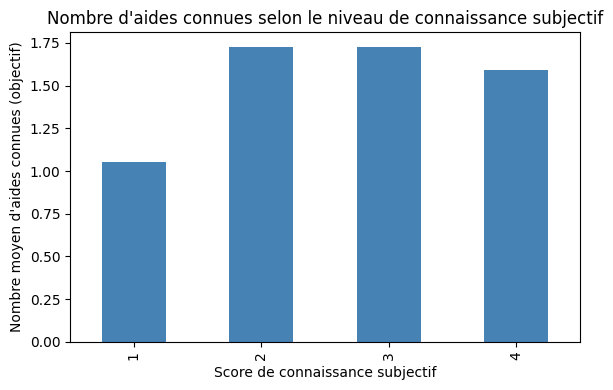

Moyenne du score subjectif selon le nombre d'aides connues :
score_aides_connues
0    2.757576
1    1.868852
2    2.347826
3    2.500000
4    2.500000
5    2.800000
6    2.714286
Name: connaissance_score, dtype: float64


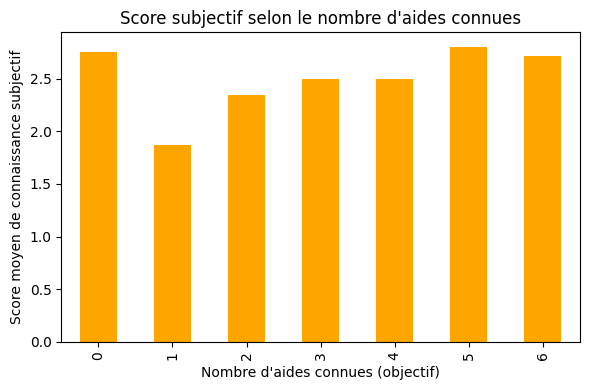

Corrélation r = 0.14, p-value = 0.0366
✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.
                             OLS Regression Results                            
Dep. Variable:     score_aides_connues   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.015
Method:                  Least Squares   F-statistic:                     4.421
Date:                 Mon, 26 May 2025   Prob (F-statistic):             0.0366
Time:                         03:57:10   Log-Likelihood:                -402.21
No. Observations:                  232   AIC:                             808.4
Df Residuals:                      230   BIC:                             815.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      

In [86]:
# Moyenne du nombre d'aides connues selon le score subjectif
mean_aides_by_connaissance = df.groupby('connaissance_score')['score_aides_connues'].mean()
print("Moyenne du nombre d'aides connues selon le score subjectif :")
print(mean_aides_by_connaissance)

plt.figure(figsize=(6,4))
mean_aides_by_connaissance.plot(kind='bar', color='steelblue')
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre moyen d'aides connues (objectif)")
plt.title("Nombre d'aides connues selon le niveau de connaissance subjectif")
plt.tight_layout()
plt.show()

# Moyenne du score subjectif selon le nombre d'aides connues
mean_connaissance_by_aides = df.groupby('score_aides_connues')['connaissance_score'].mean()
print("Moyenne du score subjectif selon le nombre d'aides connues :")
print(mean_connaissance_by_aides)

plt.figure(figsize=(6,4))
mean_connaissance_by_aides.plot(kind='bar', color='orange')
plt.xlabel("Nombre d'aides connues (objectif)")
plt.ylabel("Score moyen de connaissance subjectif")
plt.title("Score subjectif selon le nombre d'aides connues")
plt.tight_layout()
plt.show()

valid = df[['connaissance_score', 'score_aides_connues']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['score_aides_connues'])
print(f"Corrélation r = {r:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.")
else:
    print("❌ Corrélation non significative. Pas de lien entre la connaissance des aides et la perception de la connaissance.")

import statsmodels.api as sm
X = sm.add_constant(valid['connaissance_score'])
y = valid['score_aides_connues']
model = sm.OLS(y, X).fit()
print(model.summary())

#


**Relationship Between Subjective Knowledge and Number of Known Financial Aids**

### Table 1. Average Number of Aids Known by Subjective Knowledge Score

| Subjective Knowledge Score | Average Number of Aids Known |
|---------------------------|------------------------------|
| 1 (Not at all)            | 1.05                         |
| 2 (A little)              | 1.72                         |
| 3 (Fairly well)           | 1.73                         |
| 4 (Very well)             | 1.59                         |

### Table 2. Average Subjective Knowledge Score by Number of Aids Known

| Number of Aids Known | Average Subjective Knowledge Score |
|----------------------|-----------------------------------|
| 0                    | 2.76                              |
| 1                    | 1.87                              |
| 2                    | 2.35                              |
| 3                    | 2.50                              |
| 4                    | 2.50                              |
| 5                    | 2.80                              |
| 6                    | 2.71                              |

### Statistical Results

- **Pearson correlation:**  
  r = 0.14, p-value = 0.0366  
  ✅ Significant correlation: the more respondents feel knowledgeable, the more aids they can name.

- **OLS Regression:**  
  - Coefficient for subjective knowledge score: **0.20** (p = 0.037)  
  - R² = 0.019 (very low, so the effect is weak but significant)

| Variable            | Coefficient | Std. Error | t      | P-value | 95% CI (lower) | 95% CI (upper) |
|---------------------|-------------|------------|--------|---------|----------------|----------------|
| Intercept           | 1.10        | 0.23       | 4.83   | 0.000   | 0.65           | 1.54           |
| Knowledge Score     | 0.20        | 0.10       | 2.10   | 0.037   | 0.01           | 0.39           |

### Main Findings

- Respondents who rate their knowledge of EVs and infrastructure higher also tend to know more about available financial aids.
- The relationship is statistically significant but weak (low R² and correlation).
- The average number of aids known increases from 1.05 (for those not interested) to about 1.7 for those who feel more informed, but does not increase further for the highest self-rated group.
- Conversely, those who know zero aids tend to rate their subjective knowledge higher than those who know just one, suggesting some overconfidence or lack of awareness.


### Brief Analysis

There is a small but significant association between how well respondents think they know the EV ecosystem and the number of financial aids they can actually name. However, this relationship is weak, suggesting that even people who feel well-informed may not have a much broader knowledge of available aids. This highlights the need for clearer, more accessible information about financial incentives, even among audiences who are already interested in electric vehicles. Improving the visibility and clarity of these aids could help support adoption.

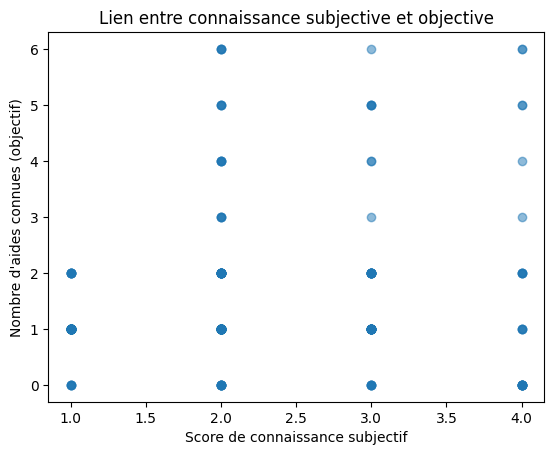

In [87]:
plt.scatter(df['connaissance_score'], df['score_aides_connues'], alpha=0.5)
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre d'aides connues (objectif)")
plt.title("Lien entre connaissance subjective et objective")
plt.show()

## **User experience and perceived sufficiency**  
  (Personal experience with charging—problems encountered, perceived adequacy of the network)

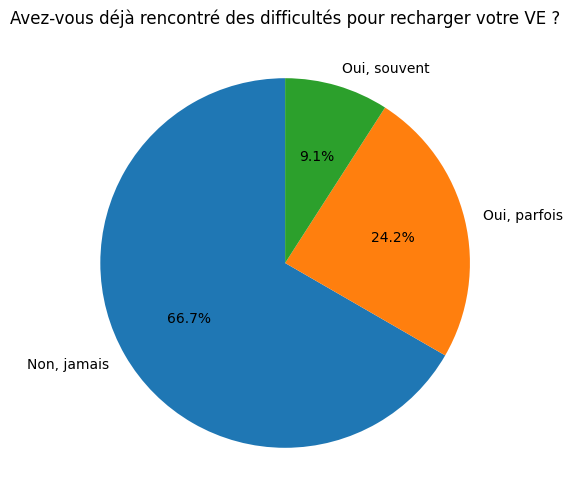

Répartition des réponses à la question sur les difficultés de recharge :
Non, jamais: 22
Oui, parfois: 8
Oui, souvent: 3


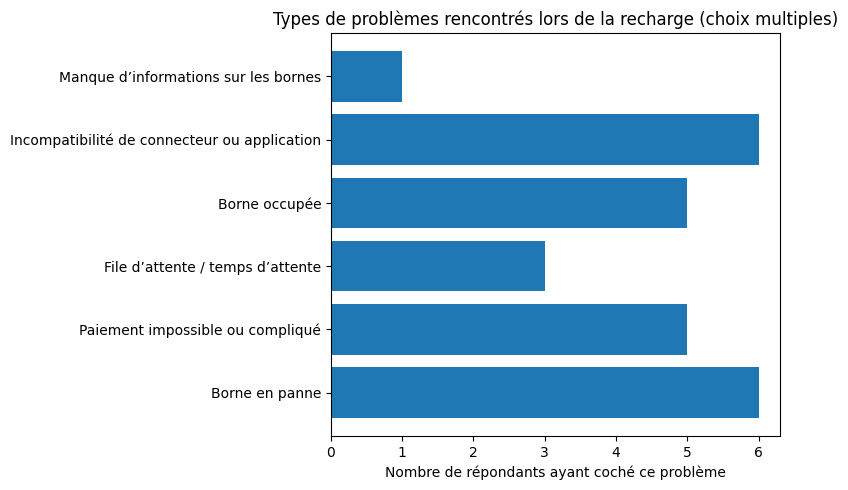

Nombre de répondants ayant rencontré chaque type de problème :
Borne en panne: 6
Paiement impossible ou compliqué: 5
File d’attente / temps d’attente: 3
Borne occupée: 5
Incompatibilité de connecteur ou application: 6
Manque d’informations sur les bornes: 1


In [88]:

col_pb = "Avez-vous déjà rencontré des difficultés pour recharger votre véhicule électrique ?\n"
pb_cols = [
    'Quels types de problèmes rencontrez-vous ? (Borne en panne)',
    'Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)',
    'Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)',
    'Quels types de problèmes rencontrez-vous ? (Borne occupée)',
    'Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)',
    'Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)'
]

# Sécurise le typage des colonnes pb_cols (0/1)
for col in pb_cols:
    if df[col].dtype != bool and not np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].astype(str).str.strip().str.lower().map({'true': 1, 'vrai': 1, 'oui': 1, '1': 1, 'false': 0, 'faux': 0, 'non': 0, '0': 0})
    df[col] = df[col].fillna(0).astype(int)

# 1. Camembert principal (toutes modalités)
main_counts = df[col_pb].value_counts(dropna=True)
main_labels = main_counts.index.tolist()
main_sizes = main_counts.values

plt.figure(figsize=(6,6))
plt.pie(main_sizes, labels=main_labels, autopct='%1.1f%%', startangle=90)
plt.title("Avez-vous déjà rencontré des difficultés pour recharger votre VE ?")
plt.show()

# Affichage des valeurs en format texte
print("Répartition des réponses à la question sur les difficultés de recharge :")
for label, value in zip(main_labels, main_sizes):
    print(f"{label}: {value}")

# 2. Barres horizontales pour les types de problèmes (nombre de répondants)
pb_counts = df[pb_cols].sum()
pb_labels = [col.split('?',1)[-1].strip(' ()') for col in pb_cols]

plt.figure(figsize=(8,5))
plt.barh(pb_labels, pb_counts)
plt.xlabel("Nombre de répondants ayant coché ce problème")
plt.title("Types de problèmes rencontrés lors de la recharge (choix multiples)")
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("Nombre de répondants ayant rencontré chaque type de problème :")
for label, value in zip(pb_labels, pb_counts):
    print(f"{label}: {value}")

**Expérience utilisateur et perception de la suffisance du réseau**

### Répartition des réponses à la question sur les difficultés de recharge

| Réponse         | Nombre de répondants |
|-----------------|---------------------|
| Non, jamais     | 22                  |
| Oui, parfois    | 8                   |
| Oui, souvent    | 3                   |

### Types de problèmes rencontrés lors de la recharge

| Type de problème                              | Nombre de répondants |
|-----------------------------------------------|---------------------|
| Borne en panne                                | 6                   |
| Paiement impossible ou compliqué              | 5                   |
| File d’attente / temps d’attente              | 3                   |
| Borne occupée                                | 5                   |
| Incompatibilité de connecteur ou application  | 6                   |
| Manque d’informations sur les bornes          | 1                   |

### Idées principales

- **La majorité des répondants (22 sur 33) n’a jamais rencontré de difficulté pour recharger leur véhicule électrique.**
- **Les problèmes les plus fréquents sont les bornes en panne et l’incompatibilité de connecteur ou d’application (6 répondants chacun), suivis par les difficultés de paiement et les bornes occupées (5 répondants chacun).**
- **Les files d’attente et le manque d’informations sont moins souvent cités.**

### Brève analyse

L’expérience utilisateur semble globalement positive, avec une majorité de répondants n’ayant jamais rencontré de problème de recharge. Cependant, une minorité significative rapporte des difficultés, principalement liées à la fiabilité technique (bornes en panne, incompatibilité) et à l’accès (paiement, borne occupée). Ces obstacles, bien que minoritaires, peuvent nuire à la confiance dans le réseau et freiner l’adoption des véhicules électriques. Il est donc important de renforcer la fiabilité des infrastructures et de simplifier l’expérience utilisateur pour lever ces freins résiduels.

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?
Non    190
Oui     42
Name: count, dtype: int64


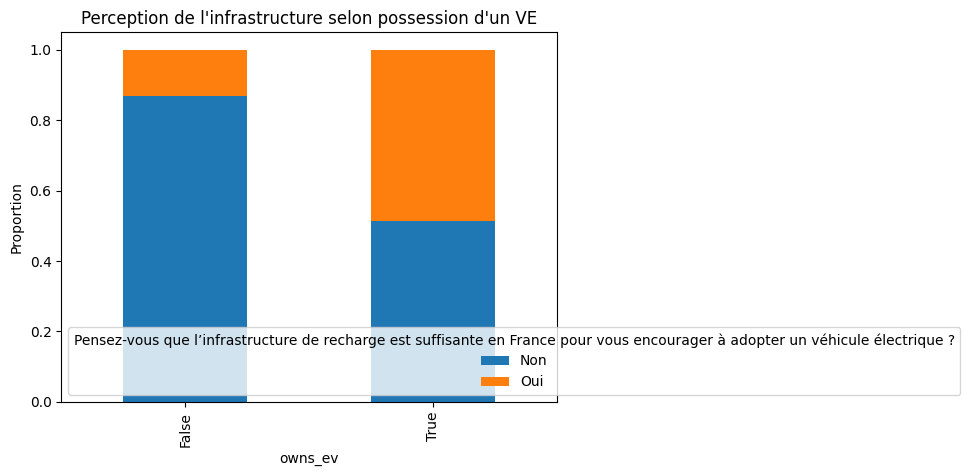

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?,Non,Oui
owns_ev,,
False,173,26
True,17,16



Test du Chi² : p-value = 0.00000332
✅ La perception de l'infrastructure diffère significativement selon la possession d'un VE.


In [89]:
# 3.2 Perception de la suffisance de l’infrastructure
print(df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"].value_counts(dropna=False))

# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

pd.crosstab(df['owns_ev'], df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Perception de l'infrastructure selon possession d'un VE")
plt.ylabel("Proportion")
plt.show()

# ...existing code...
# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

ct = pd.crosstab(
    df['owns_ev'],
    df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"]
)
display(ct)

# Test du Chi² d'indépendance
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(ct)
print(f"\nTest du Chi² : p-value = {p:.8f}")
if p < 0.05:
    print("✅ La perception de l'infrastructure diffère significativement selon la possession d'un VE.")
else:
    print("❌ Pas de différence significative selon la possession d'un VE.")



**Perception of Charging Infrastructure Sufficiency**
- **Overall distribution:**
    - No: 190 respondents
    - Yes: 42 respondents

- **By electric vehicle ownership:**

| Owns an EV | No  | Yes |
|:----------:|:---:|:---:|
| No         | 173 | 26  |
| Yes        | 17  | 16  |

- **Chi² independence test**
    - p-value = 0.00000332  
    - ✅ Perception of infrastructure sufficiency differs significantly depending on EV ownership.

**Interpretation:**
- EV owners are much more likely to consider the infrastructure sufficient (16/33, or 48%) than non-owners (26/199, or 13%).
- This difference is highly statistically significant.
- This suggests that real-world charging experience improves perception of the network, while non-owners remain more skeptical.


In [90]:
infra_col = "Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"
geo_col = "Habitez-vous dans :"

# Nettoyage
df[infra_col] = df[infra_col].str.strip()
df[geo_col] = df[geo_col].str.strip()

# Tableau croisé
ct = pd.crosstab(df[geo_col], df[infra_col])
display(ct)


# Test du Chi²
chi2, p, dof, _ = chi2_contingency(ct)
print(f"\nChi² = {chi2:.2f} | p = {p:.4f}")


Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?,Non,Oui
Habitez-vous dans :,,
Une grande ville,64,20
Une ville moyenne,61,9
Une zone périurbaine,37,10
Une zone rurale,28,3



Chi² = 4.95 | p = 0.1757


**Perception of Charging Infrastructure Sufficiency by Area Type**

| Area Type         | No  | Yes |
|-------------------|-----|-----|
| Large city        | 64  | 20  |
| Medium-sized city | 61  | 9   |
| Suburban area     | 37  | 10  |
| Rural area        | 28  | 3   |

**Chi² test:**  
Chi² = 4.95 | p = 0.1757

**Interpretation:**
- Respondents in large cities are somewhat more likely to consider the charging infrastructure sufficient (24%) than those in rural areas (10%).
- However, the difference across area types is **not statistically significant** (p = 0.18).
- This suggests that, in this sample, geographic location does not have a significant impact on the perceived sufficiency of charging infrastructure.


Problème : Quels types de problèmes rencontrez-vous ? (Borne en panne)
  - Taux de réadoption si problème rencontré : 0.67 (n=6)
  - Taux de réadoption si PAS ce problème : 0.96 (n=25)
  - T-test : t = -1.37, p = 0.2261
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)
  - Taux de réadoption si problème rencontré : 0.80 (n=5)
  - Taux de réadoption si PAS ce problème : 0.92 (n=26)
  - T-test : t = -0.59, p = 0.5802
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)
  - Taux de réadoption si problème rencontré : 0.67 (n=3)
  - Taux de réadoption si PAS ce problème : 0.93 (n=28)
  - T-test : t = -0.78, p = 0.5154
  ❌ Pas de différence significative.

Problème : Quels types de problèmes rencontrez-vous ? (Borne occupée)
  - Taux de réadoption si problème rencontré : 0.40 (n=5)
  - Taux de réadoption si PAS ce problème : 1.00 (n=26)
  - T

c:\Users\Mango\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


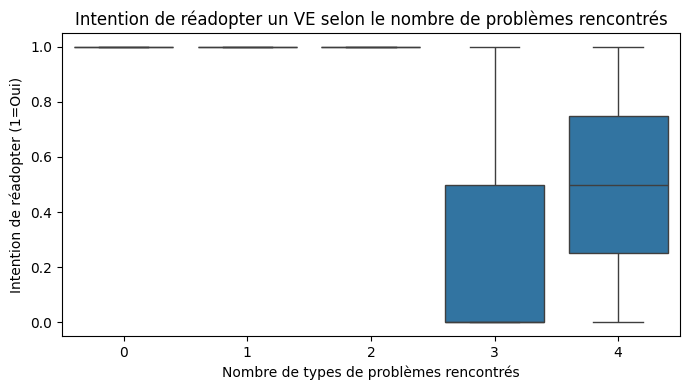

In [91]:

pb_cols = [
    'Quels types de problèmes rencontrez-vous ? (Borne en panne)',
    'Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)',
    'Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)',
    'Quels types de problèmes rencontrez-vous ? (Borne occupée)',
    'Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)',
    'Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)'
]
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"

# Recodage intention de réadopter (1 = intention positive, 0 = négative)
repurchase_map = {
    "Totalement d'accord": 1,
    "Plutôt d'accord": 1,
    "Plutôt en désaccord": 0,
    "Totalement en désaccord": 0,
    "Oui": 1,
    "Non": 0
}
df['repurchase_bin'] = df[repurchase_col].map(repurchase_map)

# Analyse pour chaque type de problème
for col in pb_cols:
    # On ne garde que les propriétaires de VE ayant répondu à la question de réadoption
    mask = df['repurchase_bin'].notna()
    group_pb = df.loc[mask & (df[col] == 1), 'repurchase_bin']
    group_no_pb = df.loc[mask & (df[col] == 0), 'repurchase_bin']
    print(f"\nProblème : {col}")
    print(f"  - Taux de réadoption si problème rencontré : {group_pb.mean():.2f} (n={len(group_pb)})")
    print(f"  - Taux de réadoption si PAS ce problème : {group_no_pb.mean():.2f} (n={len(group_no_pb)})")
    # Test statistique (t-test)
    from scipy.stats import ttest_ind
    if len(group_pb) > 1 and len(group_no_pb) > 1:
        tstat, pval = ttest_ind(group_pb, group_no_pb, equal_var=False)
        print(f"  - T-test : t = {tstat:.2f}, p = {pval:.4f}")
        if pval < 0.05:
            print("  ✅ Différence significative sur l'intention de réadopter selon ce problème.")
        else:
            print("  ❌ Pas de différence significative.")
    else:
        print("  Pas assez de données pour le test statistique.")

# Visualisation synthétique : boxplot du score de réadoption selon nombre de problèmes rencontrés
df['nb_problemes'] = df[pb_cols].sum(axis=1)
plt.figure(figsize=(7,4))
sns.boxplot(x='nb_problemes', y='repurchase_bin', data=df)
plt.xlabel("Nombre de types de problèmes rencontrés")
plt.ylabel("Intention de réadopter (1=Oui)")
plt.title("Intention de réadopter un VE selon le nombre de problèmes rencontrés")
plt.tight_layout()
plt.show()



**Impact of Charging Problems on Intention to Repurchase an EV**

For each type of charging problem, the intention to repurchase an electric vehicle (EV) was compared between those who experienced the problem and those who did not:

| Problem Type                                 | Repurchase Rate if Problem | Repurchase Rate if No Problem | t-test (p-value) | Significant? |
|----------------------------------------------|---------------------------|------------------------------|------------------|--------------|
| Broken charging station                      | 67% (n=6)                 | 96% (n=25)                   | p = 0.2261       | ❌ No        |
| Payment impossible or complicated            | 80% (n=5)                 | 92% (n=26)                   | p = 0.5802       | ❌ No        |
| Waiting line / waiting time                  | 67% (n=3)                 | 93% (n=28)                   | p = 0.5154       | ❌ No        |
| Occupied charging station                    | 40% (n=5)                 | 100% (n=26)                  | p = 0.0705       | ❌ No        |
| Connector/app incompatibility                | 50% (n=6)                 | 100% (n=25)                  | p = 0.0756       | ❌ No        |
| Lack of information about charging stations  | 100% (n=1)                | 90% (n=30)                   | Not enough data  | ❌ No        |

**Interpretation:**
- For all types of problems, the intention to repurchase is lower among those who experienced the issue, but none of the differences reach statistical significance (all p > 0.05).
- The largest gaps are for "occupied charging station" and "connector/app incompatibility," but the sample sizes are small and results are not significant.
- **Conclusion:** While charging problems may reduce the intention to repurchase an EV, this effect is not statistically significant in this sample.

In [92]:
from scipy.stats import pointbiserialr

valid = df[['nb_problemes', 'repurchase_bin']].dropna()

r, p = pearsonr(valid['nb_problemes'], valid['repurchase_bin'])
print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

# Point-biserial correlation (equivalent to Pearson here)
r_pb, p_pb = pointbiserialr(valid['repurchase_bin'], valid['nb_problemes'])
print(f"Point-biserial correlation: r = {r_pb:.2f}, p = {p_pb:.4f}")

if p < 0.05:
    print("✅ Significant negative correlation: more problems are associated with lower intention to repurchase.")
else:
    print("❌ No significant correlation between number of problems and intention to repurchase.")
# ...existing code...

Pearson correlation: r = -0.62, p = 0.0002
Point-biserial correlation: r = -0.62, p = 0.0002
✅ Significant negative correlation: more problems are associated with lower intention to repurchase.


**Correlation Between Number of Charging Problems and Intention to Repurchase an EV**

- **Pearson correlation:** r = -0.62, p = 0.0002  
- **Point-biserial correlation:** r = -0.62, p = 0.0002  
- ✅ **Significant negative correlation:** The more types of charging problems respondents have experienced, the lower their intention to repurchase an electric vehicle.

**Interpretation:**  
This strong and statistically significant negative correlation indicates that user experience with charging problems is a key factor in the decision to repurchase an EV. Addressing and reducing these problems could therefore be crucial for improving user satisfaction and encouraging long-term adoption.

Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = 0.05
Moyenne intention (infrastructure OK): 1.57
Moyenne intention (infrastructure pas OK): 1.42
T-test: t = 0.57, p = 0.5726


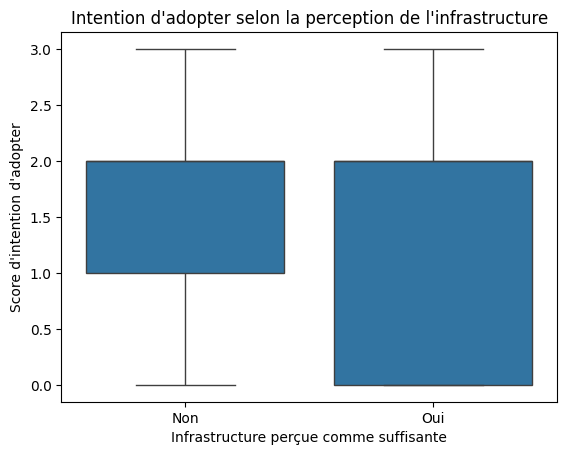

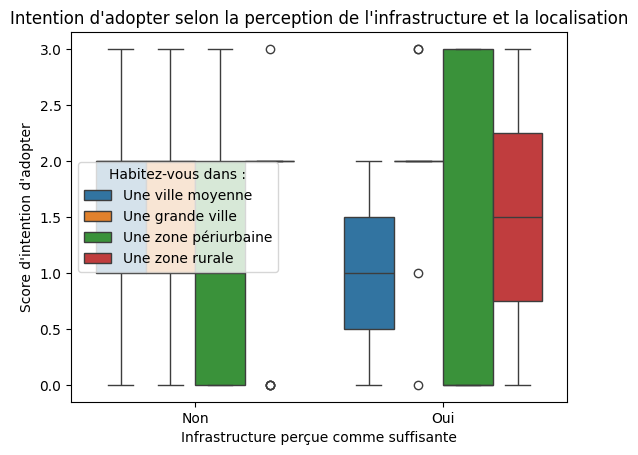

In [93]:
# Mapping intention + perception infrastructure
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
df['intention_score'] = df[intention_col].map({
    "Totalement d'accord": 3,
    "Plutôt d'accord": 2,
    "Plutôt en désaccord": 1,
    "Totalement en désaccord": 0
})


df['infra_ok'] = df[infra_col].map({'Oui': 1, 'Non': 0})

corr = df[['intention_score', 'infra_ok']].dropna().corr().iloc[0,1]
print(f"Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = {corr:.2f}")


group_yes = df[df['infra_ok'] == 1]['intention_score'].dropna()
group_no = df[df['infra_ok'] == 0]['intention_score'].dropna()
tstat, pval = ttest_ind(group_yes, group_no, equal_var=False)
print(f"Moyenne intention (infrastructure OK): {group_yes.mean():.2f}")
print(f"Moyenne intention (infrastructure pas OK): {group_no.mean():.2f}")
print(f"T-test: t = {tstat:.2f}, p = {pval:.4f}")

sns.boxplot(x='infra_ok', y='intention_score', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure")
plt.show()

sns.boxplot(x='infra_ok', y='intention_score', hue='Habitez-vous dans :', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure et la localisation")
plt.show()

**Corrélation entre perception positive de l'infrastructure et intention d'adopter un VE**

- **Coefficient de corrélation :** r = 0.05 (très faible)
- **Moyenne du score d'intention si infrastructure jugée suffisante :** 1.57
- **Moyenne du score d'intention si infrastructure jugée insuffisante :** 1.42
- **T-test :** t = 0.57, p = 0.5726

**Interprétation :**  
Il n’existe pas de lien significatif entre le fait de percevoir l’infrastructure de recharge comme suffisante et l’intention d’adopter un véhicule électrique (p > 0.05). La différence de score moyen d’intention est faible et non significative. Dans cet échantillon, la perception de la suffisance du réseau n’influence donc pas fortement l’intention d’adopter un VE.

## **Improvement priorities**  
  (User priorities for future infrastructure: coverage, reliability, speed, information)

## **Influence of user profile**  
  (How geographic area and ownership status affect charging experience and perceptions)


Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  0.025862
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                0.021552
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                0.012931
Quels types de problèmes rencontrez-vous ? (Borne occupée)                                   0.021552
Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)    0.025862
Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)            0.004310
dtype: float64
Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  6
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                5
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                3
Quels types de problèmes rencontrez-vous ? (Borne occupée)                              

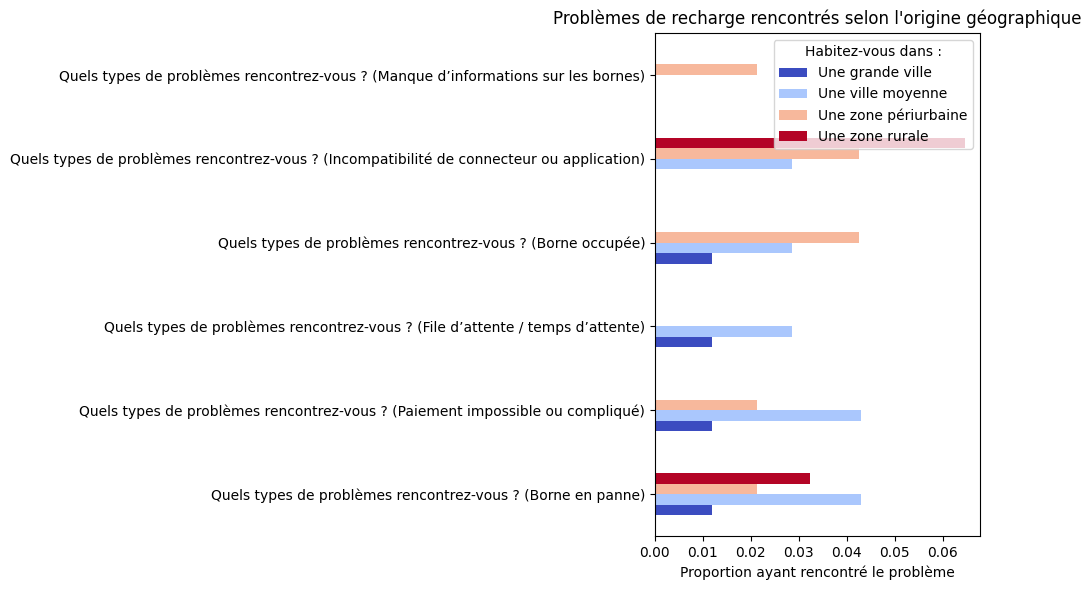

Proportion de répondants ayant rencontré chaque problème par zone géographique :

Quels types de problèmes rencontrez-vous ? (Borne en panne):
  Une grande ville: 1.2%
  Une ville moyenne: 4.3%
  Une zone périurbaine: 2.1%
  Une zone rurale: 3.2%

Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué):
  Une grande ville: 1.2%
  Une ville moyenne: 4.3%
  Une zone périurbaine: 2.1%
  Une zone rurale: 0.0%

Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente):
  Une grande ville: 1.2%
  Une ville moyenne: 2.9%
  Une zone périurbaine: 0.0%
  Une zone rurale: 0.0%

Quels types de problèmes rencontrez-vous ? (Borne occupée):
  Une grande ville: 1.2%
  Une ville moyenne: 2.9%
  Une zone périurbaine: 4.3%
  Une zone rurale: 0.0%

Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application):
  Une grande ville: 0.0%
  Une ville moyenne: 2.9%
  Une zone périurbaine: 4.3%
  Une zone rurale: 6.5%

Quels types de problème

In [94]:
print(df[pb_cols].mean())
print(df[pb_cols].sum())

# Moyenne par lieu
problem_by_geo = df.groupby("Habitez-vous dans :")[pb_cols].mean().T
problem_by_geo.plot(kind='barh', figsize=(10,6), colormap='coolwarm')
plt.title("Problèmes de recharge rencontrés selon l'origine géographique")
plt.xlabel("Proportion ayant rencontré le problème")
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("Proportion de répondants ayant rencontré chaque problème par zone géographique :")
for pb in problem_by_geo.index:
    print(f"\n{pb}:")
    for geo in problem_by_geo.columns:
        print(f"  {geo}: {problem_by_geo.loc[pb, geo]:.1%}")


**Summary: Charging Problems by Geographic Area**

#### **Overall frequency of problems (all respondents)**
| Problem type                                   | % of respondents | Count |
|------------------------------------------------|------------------|-------|
| Broken charging station                        | 2.6%             | 6     |
| Payment impossible or complicated              | 2.2%             | 5     |
| Waiting line / waiting time                    | 1.3%             | 3     |
| Occupied charging station                      | 2.2%             | 5     |
| Connector/app incompatibility                  | 2.6%             | 6     |
| Lack of information about charging stations    | 0.4%             | 1     |

#### **Variation by geographic area (% of respondents who experienced each problem)**

| Problem type                                   | Large city | Medium city | Suburban area | Rural area |
|------------------------------------------------|------------|-------------|---------------|------------|
| Broken charging station                        | 1.2%       | 4.3%        | 2.1%          | 3.2%       |
| Payment impossible or complicated              | 1.2%       | 4.3%        | 2.1%          | 0.0%       |
| Waiting line / waiting time                    | 1.2%       | 2.9%        | 0.0%          | 0.0%       |
| Occupied charging station                      | 1.2%       | 2.9%        | 4.3%          | 0.0%       |
| Connector/app incompatibility                  | 0.0%       | 2.9%        | 4.3%          | 6.5%       |
| Lack of information about charging stations    | 0.0%       | 0.0%        | 2.1%          | 0.0%       |

#### **Key points**
- **Problems remain rare** (less than 3% of respondents for each type).
- **Medium-sized cities:** most problems are more frequent here.
- **Suburban and rural areas:** connector/app incompatibility is more often cited (up to 6.5% in rural areas).
- **Large cities:** very few problems reported (1.2% or less for each type).
- **Lack of information:** only mentioned in suburban areas.

**Conclusion:**  
Charging problems are marginal but vary by area: medium-sized and suburban cities are most exposed, while large cities are the "safest." Technical incompatibility is a notable issue in rural and suburban areas.

## **multivariate (cross) analyses** 

,Nombre de répondants
Habitez-vous dans :,
Une grande ville,84
Une ville moyenne,70
Une zone périurbaine,47
Une zone rurale,31


,Nombre de répondants
Avez-vous accès à une place de parking personnelle ?,
"Oui, avec borne de recharge ou possibilité d'en installer une (à domicile ou en résidence par exemple)",99
"Oui, sans borne de recharge ou possibilité d'en installer une",82
Non,51


Fréquence de chaque type de borne connue :


,Type de borne connue,Nombre de répondants
0,Oui,274
1,"des bornes ""privées"" (Supermarché",119
2,lieu de travail...),119
3,des bornes publiques,110
4,Non,55
5,je n'en vois pas,55
6,à domicile (maison,45
7,résidence...),45


borne_type,Non,Oui,"des bornes ""privées"" (Supermarché",des bornes publiques,je n'en vois pas,lieu de travail...),résidence...),à domicile (maison
Habitez-vous dans :,,,,,,,,
Une grande ville,0.077441,0.323232,0.127946,0.124579,0.077441,0.127946,0.070707,0.070707
Une ville moyenne,0.066116,0.338843,0.148760,0.148760,0.066116,0.148760,0.041322,0.041322
Une zone périurbaine,0.058824,0.331551,0.160428,0.112299,0.058824,0.160428,0.058824,0.058824
Une zone rurale,0.052083,0.354167,0.156250,0.166667,0.052083,0.156250,0.031250,0.031250


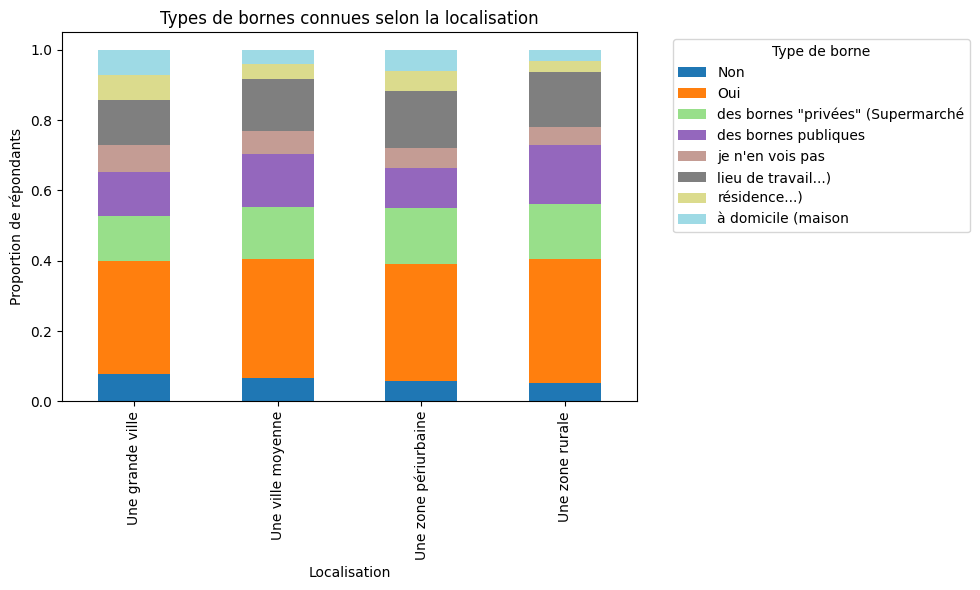


Proportion de répondants citant chaque type de borne par localisation (tableau) :


borne_type,Non,Oui,"des bornes ""privées"" (Supermarché",des bornes publiques,je n'en vois pas,lieu de travail...),résidence...),à domicile (maison
Habitez-vous dans :,,,,,,,,
Une grande ville,7.74%,32.32%,12.79%,12.46%,7.74%,12.79%,7.07%,7.07%
Une ville moyenne,6.61%,33.88%,14.88%,14.88%,6.61%,14.88%,4.13%,4.13%
Une zone périurbaine,5.88%,33.16%,16.04%,11.23%,5.88%,16.04%,5.88%,5.88%
Une zone rurale,5.21%,35.42%,15.62%,16.67%,5.21%,15.62%,3.12%,3.12%


Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?,"Non, je n'en vois pas","Non, je n'en vois pas, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Non, je n'en vois pas, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...), Oui, des bornes publiques","Oui, des bornes publiques","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, à domicile (maison, résidence...), Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)"
Habitez-vous dans :,,,,,,,,,,,,,,,,,
Une grande ville,23,0,0,12,3,0,6,1,17,8,7,1,0,5,1,0,0
Une ville moyenne,15,1,0,13,3,1,2,0,16,12,4,0,0,3,0,0,0
Une zone périurbaine,10,0,1,10,2,1,2,0,4,10,2,0,0,2,1,1,1
Une zone rurale,5,0,0,9,1,0,1,0,10,3,0,1,1,0,0,0,0


,"Non, je n'en vois pas","Non, je n'en vois pas, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Non, je n'en vois pas, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...), Oui, des bornes publiques","Oui, des bornes publiques","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...)","Oui, des bornes publiques, Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...)","Oui, à domicile (maison, résidence...), Oui, des bornes ""privées"" (Supermarché, lieu de travail...), Oui, des bornes publiques","Oui, à domicile (maison, résidence...), Oui, des bornes publiques, Oui, des bornes ""privées"" (Supermarché, lieu de travail...)"
Localisation,,,,,,,,,,,,,,,,,
Une grande ville,19.19,0.36,0.36,15.93,3.26,0.72,3.98,0.36,17.02,11.95,4.71,0.72,0.36,3.62,0.72,0.36,0.36
Une ville moyenne,15.99,0.30,0.30,13.28,2.72,0.60,3.32,0.30,14.18,9.96,3.92,0.60,0.30,3.02,0.60,0.30,0.30
Une zone périurbaine,10.74,0.20,0.20,8.91,1.82,0.41,2.23,0.20,9.52,6.69,2.63,0.41,0.20,2.03,0.41,0.20,0.20
Une zone rurale,7.08,0.13,0.13,5.88,1.20,0.27,1.47,0.13,6.28,4.41,1.74,0.27,0.13,1.34,0.27,0.13,0.13


Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993
Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993

--- Analyse automatique ---
❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.

Tendances globales :
- 'Non' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'Oui' : en moyenne 33.7% des répondants la citent, toutes zones confondues.
- 'des bornes "privées" (Supermarché' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'des bornes publiques' : en moyenne 13.8% des répondants la citent, toutes zones confondues.
- 'je n'en vois pas' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'lieu de travail...)' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'résidence...)' : en moyenne 5.1% des répondants la citent, toutes zones confondues.
- 'à domicile (maison' : en moyenne 5.1% des répondants la citent, toutes zon

In [95]:
# 1.1 Répartition des répondants par type de localisation
# Affichage sous forme de tableau pour la localisation
display(df['Habitez-vous dans :'].value_counts(dropna=False).to_frame("Nombre de répondants"))

display(df['Avez-vous accès à une place de parking personnelle ?'].value_counts(dropna=False).to_frame("Nombre de répondants"))

# 1.3 Connaissance de bornes accessibles près de chez soi
# Si les réponses sont séparées par des virgules, on "explose" la colonne en plusieurs valeurs
bornes_accessibles_col = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[bornes_accessibles_col] = df[bornes_accessibles_col].astype(str)

# On sépare les réponses multiples et on les met à plat
from collections import Counter
import pandas as pd

all_answers_bornes_accessibles = df[bornes_accessibles_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers_bornes_accessibles = [item for sublist in all_answers_bornes_accessibles for item in sublist]

# Compte la fréquence de chaque réponse
answer_counts = Counter(flat_answers_bornes_accessibles)
print("Fréquence de chaque type de borne connue :")
answer_counts_df = pd.DataFrame(answer_counts.most_common(), columns=["Type de borne connue", "Nombre de répondants"])
display(answer_counts_df)

# ...existing code...

col_loc = 'Habitez-vous dans :'
col_bornes = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[col_bornes] = df[col_bornes].astype(str)

# On crée un DataFrame "explosé" : une ligne par type de borne connue
df_exploded = df.assign(
    borne_type=df[col_bornes].str.split(',')
).explode('borne_type')
df_exploded['borne_type'] = df_exploded['borne_type'].str.strip()
df_exploded = df_exploded[df_exploded['borne_type'].notna() & (df_exploded['borne_type'] != '')]

# Tableau croisé
crosstab = pd.crosstab(df_exploded[col_loc], df_exploded['borne_type'], normalize='index')

# Affichage du tableau croisé sous forme de DataFrame
display(crosstab)

crosstab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Types de bornes connues selon la localisation")
plt.ylabel("Proportion de répondants")
plt.xlabel("Localisation")
plt.legend(title="Type de borne", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Affichage des valeurs en format texte
print("\nProportion de répondants citant chaque type de borne par localisation (tableau) :")
display(crosstab.style.format("{:.2%}").set_caption("Proportion de répondants citant chaque type de borne par localisation"))

# 1.5 Test du Chi² localisation vs connaissance de bornes
ct = pd.crosstab(df['Habitez-vous dans :'], df['Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'])
display(ct)
chi2, p, dof, expected = chi2_contingency(ct)
display(pd.DataFrame(expected, index=ct.index, columns=ct.columns).round(2).rename_axis(index='Localisation', columns='Type de borne').rename_axis(None, axis=1))
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")
# ...existing code...
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")

# Analyse automatique des résultats
print("\n--- Analyse automatique ---")
if p < 0.05:
    print("✅ Il existe une différence significative dans la connaissance des types de bornes selon la localisation des répondants.")
    # Exemple d'analyse simple : repérer les bornes les plus connues par zone
    for loc in crosstab.index:
        top_borne = crosstab.loc[loc].idxmax()
        top_val = crosstab.loc[loc].max()
        print(f"- Dans '{loc}', la borne la plus souvent citée est : '{top_borne}' ({top_val:.1%} des répondants de cette zone)")
else:
    print("❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.")

# Aperçu des tendances globales
print("\nTendances globales :")
for borne in crosstab.columns:
    mean_val = crosstab[borne].mean()
    print(f"- '{borne}' : en moyenne {mean_val:.1%} des répondants la citent, toutes zones confondues.")

**Respondent Distribution by Area and Parking Access**

| Area Type           | Number of Respondents |
|---------------------|----------------------|
| Large city          | 84                   |
| Medium city         | 70                   |
| Suburban area       | 47                   |
| Rural area          | 31                   |

| Access to Private Parking                                      | Number of Respondents |
|---------------------------------------------------------------|----------------------|
| Yes, with charging point or possibility to install one         | 99                   |
| Yes, without charging point or possibility to install one      | 82                   |
| No                                                            | 51                   |

---

**Frequency of Each Known Charging Point Type**

| Charging Point Type                        | Number of Respondents |
|--------------------------------------------|----------------------|
| Yes                                        | 274                  |
| Private charging points (Supermarket, etc.)| 119                  |
| Workplace                                  | 119                  |
| Public charging points                     | 110                  |
| No                                         | 55                   |
| I don't see any                            | 55                   |
| At home (house)                            | 45                   |
| Residence                                  | 45                   |

**Proportion of Respondents Citing Each Charging Point Type by Area**

| Area Type      | No    | Yes   | Private (Supermarket) | Public | I don't see any | Workplace | Residence | At home (house) |
|----------------|-------|-------|----------------------|--------|-----------------|-----------|-----------|-----------------|
| Large city     | 7.7%  | 32.3% | 12.8%                | 12.5%  | 7.7%            | 12.8%     | 7.1%      | 7.1%            |
| Medium city    | 6.6%  | 33.9% | 14.9%                | 14.9%  | 6.6%            | 14.9%     | 4.1%      | 4.1%            |
| Suburban area  | 5.9%  | 33.2% | 16.0%                | 11.2%  | 5.9%            | 16.0%     | 5.9%      | 5.9%            |
| Rural area     | 5.2%  | 35.4% | 15.6%                | 16.7%  | 5.2%            | 15.6%     | 3.1%      | 3.1%            |

**Chi² Test: Area vs. Knowledge of Charging Points**

- **p-value = 0.3993**
- ❌ No significant difference detected between areas regarding knowledge of charging point types.

**Global Trends**

- 'No': on average 6.4% of respondents mention it, all areas combined.
- 'Yes': 33.7%
- 'Private charging points (Supermarket, etc.)': 14.8%
- 'Public charging points': 13.8%
- 'I don't see any': 6.4%
- 'Workplace': 14.8%
- 'Residence': 5.1%
- 'At home (house)': 5.1%

**Summary:**  
The majority of respondents, regardless of area, are aware of at least one charging point near their home, with private and public charging points being the most frequently cited. There is no significant difference in charging point awareness by geographic area.

Résumé des clusters :


,connaissance_score,score_aides_connues,infra_ok,intention_score
cluster,,,,
0,2.842105,4.789474,0.0,1.000000
1,1.991453,1.282051,0.0,1.487179
2,2.190476,1.761905,1.0,1.571429


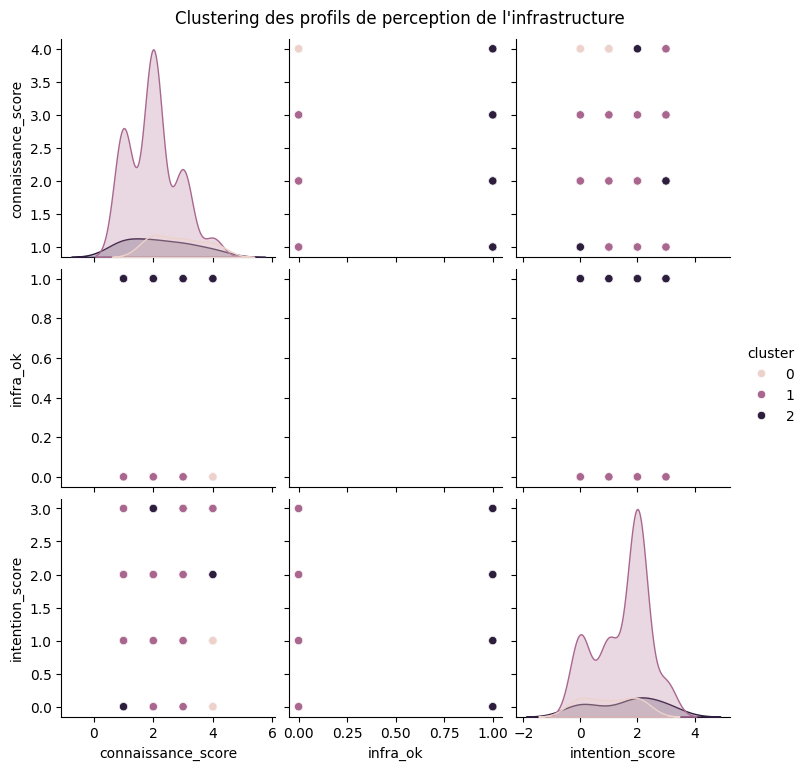

Effectif par cluster :


,Cluster,Effectif
0,1,117
1,2,21
2,0,19


In [96]:
# ...existing code...

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 1. Sélection des variables pertinentes pour le clustering
features = [
    'connaissance_score',      # Connaissance subjective
    'score_aides_connues',     # Connaissance objective (aides)
    'infra_ok',                # Perception suffisance infrastructure
    'intention_score',         # Intention d'adopter
]
df_cluster = df[features].dropna()

# 2. Mise à l'échelle des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 3. Clustering KMeans (choix de 3 clusters, ajustez si besoin)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Analyse des clusters
cluster_summary = df_cluster.groupby('cluster').mean()
print("Résumé des clusters :")
display(cluster_summary)

# 5. Visualisation (exemple 2D)
sns.pairplot(df_cluster, hue='cluster', vars=['connaissance_score', 'infra_ok', 'intention_score'])
plt.suptitle("Clustering des profils de perception de l'infrastructure", y=1.02)
plt.show()

# 6. Effectif par cluster
print("Effectif par cluster :")
display(df_cluster['cluster'].value_counts().rename_axis('Cluster').reset_index(name='Effectif'))

**Cluster Summary (KMeans Clustering Results)**

| Cluster | Subjective Knowledge | Known Aids | Perceive Infrastructure Sufficient | Adoption Intention | Cluster Size |
|---------|---------------------|------------|------------------------------------|--------------------|--------------|
|   0     | 2.84                | 4.79       | 0.0                                | 1.00               | 19           |
|   1     | 1.99                | 1.28       | 0.0                                | 1.49               | 117          |
|   2     | 2.19                | 1.76       | 1.0                                | 1.57               | 21           |

**Interpretation:**
- **Cluster 0 (n=19):** High subjective knowledge and high awareness of financial aids, but do **not** perceive the infrastructure as sufficient and have the lowest adoption intention.
- **Cluster 1 (n=117):** Low subjective knowledge and low awareness of aids, do **not** perceive the infrastructure as sufficient, and have moderate adoption intention.
- **Cluster 2 (n=21):** Medium subjective knowledge and aids awareness, **do** perceive the infrastructure as sufficient, and have the highest adoption intention.

**Key points:**
- Perceiving the infrastructure as sufficient (infra_ok = 1) is associated with the highest intention to adopt, even if knowledge and aid awareness are not the highest.
- Most respondents fall into Cluster 1 (low knowledge, low aids, low perception of sufficiency).
- The perception of infrastructure sufficiency is a key differentiator for adoption intention.

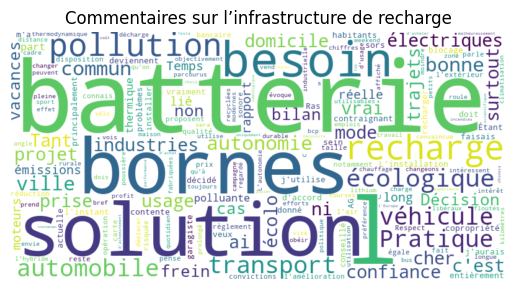

In [97]:
# 5.1 Nuage de mots sur les commentaires libres (remplace le nom de colonne si besoin)
from wordcloud import WordCloud
if "(Optionnel) Si vous souhaitez apporter des précisions :" in df.columns:
    # Liste de stopwords français de base
    stopwords = set(STOPWORDS)
    # Ajoute des mots spécifiques si besoin
    stopwords.update([
        "les","je", "des","très","sont", "aux","d'une","qu","1","1 ","suis","j'ai","être"," 1","n", "avec", "pour", "dans", "sur", "par", "que", "qui", "une", "du", "en", "et", "le", "la", "un", "au", "ce", "se", "ne", "pas", "plus", "ou", "mais", "est", "à", "de", "il", "elle", "vous", "nous", "ils", "elles", "moi", "toi", "lui", "eux", "soi", "y", "en", "tout", "tous", "toutes", "bien", "mal", "comme", "si", "aussi", "sans", "sous", "avant", "après"
        "lors", "entre", "parce", "que", "quoi", "comment", "où", "quand", "pourquoi", "qui", "quel", "quelle", "lesquels", "lesquelles", "celui", "celle", "ceux", "celles", "cela", "ça", "ceci", "cela", "là", "ici", "là-bas", "ailleurs", "telle", "tellement", "tel", "tels", "telles", "tellement"
        "toute", "toutes", "tout", "tous", "chaque", "aucun", "aucune", "nul", "nulle", "rien", "personne", "quelqu'un", "quelque chose", "certains", "certaines", "plusieurs", "beaucoup", "trop", "assez", "peu", "moins","mon", "ton", "son", "notre", "votre", "leur", "ma", "ta", "sa", "mes", "tes", "ses", "nos", "vos", "leurs", "lui-même", "elle-même", "eux-mêmes", "elles-mêmes","électrique","encore","faire","voiture","plutôt","aussi","même","autre","autres","tous","toutes","quelque","quelques","quelques-uns","quelques-unes","certains","certaines","car","d","donc","alors","ainsi","tandis","pendant","lorsque","si","comme","parce que","puisque","bien que","quoique","malgré","sauf","excepté","au-delà de", "au lieu de", "à part", "en dehors de", "à l'exception de", "hormis", "sauf que", "excepté que", "mis à part", "sans compter que", "en plus de"
    ])
    text = ' '.join(df["(Optionnel) Si vous souhaitez apporter des précisions :"].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Commentaires sur l’infrastructure de recharge")
    plt.show()

[('prix', 232), ('Centralisation des infos (application', 208), ('disponibilité)', 192), ('Meilleure maintenance du réseau', 162), ('Uniformisation des connecteurs', 161), ('Plus de recharge rapide', 156), ('Paiement simplifié', 152), ('Plus de bornes', 131), ('Meilleure maintenance du réseau Plus de bornes', 23), ('Paiement simplifié Plus de bornes', 22)]


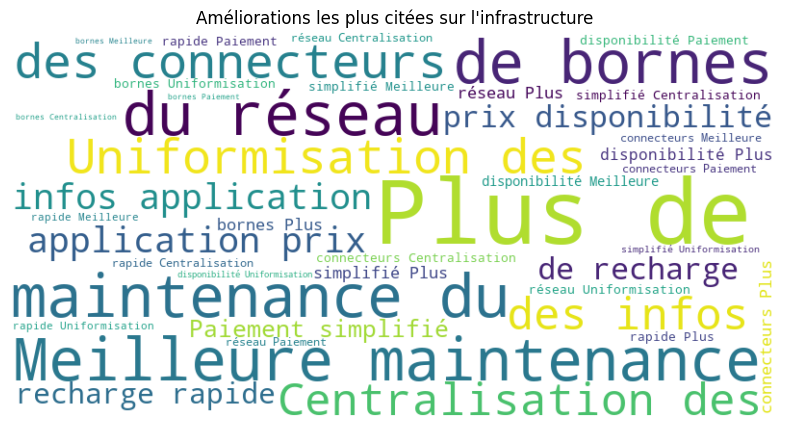

In [98]:
from collections import Counter
from wordcloud import WordCloud

priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
all_text = ' '.join(df[priority_col].dropna().tolist())
counter = Counter(all_text.split(", "))
print(counter.most_common(10))

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Améliorations les plus citées sur l'infrastructure")
plt.show()
